### **1. Setup and load data**

##### **1.1 Install dependencies and data**

In [156]:
import tensorflow as tf
import os #used for handling file operations

In [157]:
tf.config.list_physical_devices('GPU') #verify tensorflow is using the gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [158]:
# Avoid OOM errors. Setting GPU memory growth limit #### if this approach still doesn't resolve the memory consumption issue. we need to reduce size of the mini batches when training
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

#### **1.2 Load Data**

In [159]:
# # # Change working directory to notebook location# 
# notebook_path = r"E:\AKILA\RiceClassifcation"# 
# os.chdir(notebook_path# )
# print(f"Current working directory: {os.getcwd()}")

In [160]:
# import cv2i

# data_dir = "Data"
# data_dir_pat h = s.path.join(cwd, data_dirf)
# o.litdi()r(data_di:r)

In [161]:
DATA_DIR = "Data"
BATCH_SIZE = 8
IMAGE_SIZE = (260, 260)
ROOT_PATTERN = f"{DATA_DIR}/*/*/*.JPG"

In [162]:
# create dataset of file paths
paths = tf.data.Dataset.list_files(file_pattern=ROOT_PATTERN,shuffle=True)

In [163]:
# create label vocabularies


type_dirs = tf.io.gfile.listdir(DATA_DIR)
# filter, to only keep dir names
image_class_type_dirs = []  # will contain ['AT 362', 'BG 357', 'BG 360', 'BW 367',......]
for dir in type_dirs:
    if tf.io.gfile.isdir(os.path.join(DATA_DIR,dir)):
        image_class_type_dirs.append(dir)


# quality_dirs = tf.io.gfile.listdir(os.path.join(DATA_DIR,image_class_type_dirs[0]))
# filter, to only keep dir names
# image_class_quality_dirs = [] # will contain ['Bad', 'Good']
# for dir in quality_dirs:
#     if tf.io.gfile.isdir(os.path.join(DATA_DIR,image_class_type_dirs[0],dir)):
#         image_class_quality_dirs.append(dir)
image_class_quality_dirs = ['Bad', 'Good']

image_class_type_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(image_class_type_dirs),
        values=tf.constant(list(range(len(image_class_type_dirs))))
        ),
    default_value=-1
)

image_class_quality_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(image_class_quality_dirs),
        values=tf.constant(list(range(len(image_class_quality_dirs))))
    ),
    default_value=-1
)

In [164]:
# helper function to extract type and quality label 
@tf.function
def parse_label(path):
    # path format should be Data\Type\Quality\Image.JPG or Data/Type/Quality/Image.JPG
    # Normalize path: convert backslashes to forward slashes
    path = tf.strings.regex_replace(path, "\\\\", "/")
    
    # Split by forward slash
    parts = tf.strings.split(path, sep="/")
    
    # parts should be: ['Data', 'Type', 'Quality', 'Image.JPG']
    # Get the type and quality from the correct indices
    rice_type = parts[-3]
    rice_quality = parts[-2]

    t = image_class_type_table.lookup(rice_type)
    q = image_class_quality_table.lookup(rice_quality)
    return t, q

# helper function to load and preprocess image
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # Set shape before resize
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0
    return img

# act as the lambda function for the mapping
def load_item(path):
    t, q = parse_label(path)
    image = load_image(path)
    return image, {"type": t, "quality": q}

In [165]:
# Split data into training and validation sets (80/20 split)
DATASET_SIZE = len(list(paths))
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE

# Recreate paths for train/val split
paths_full = tf.data.Dataset.list_files(file_pattern=ROOT_PATTERN, shuffle=True)

# Split the dataset
train_paths = paths_full.take(TRAIN_SIZE)
val_paths = paths_full.skip(TRAIN_SIZE)

# Create training dataset
train_dataset = (
    train_paths
    .shuffle(100)
    .map(load_item, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Create validation dataset
val_dataset = (
    val_paths
    .shuffle(100)
    .map(load_item, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Total dataset size: {DATASET_SIZE}")
print(f"Training set size: {TRAIN_SIZE}")
print(f"Validation set size: {VAL_SIZE}")
print(f"Train/Val split: 80/20")

Total dataset size: 189
Training set size: 151
Validation set size: 38
Train/Val split: 80/20


### **2. Model Building**

In [166]:

# Enhanced data augmentation layer for better generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

inputs = tf.keras.Input(shape=(260, 260, 3))

x = data_augmentation(inputs)  
x = tf.keras.applications.efficientnet.preprocess_input(x)

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(260,260,3)
)
base.trainable = False

x = base(x)

type_out = tf.keras.layers.Dense(len(image_class_type_dirs), activation="softmax", name="type")(x)
quality_out = tf.keras.layers.Dense(2, activation="softmax", name="quality")(x)

model = tf.keras.Model(inputs, {"type": type_out, "quality": quality_out})

### **3. Compile**

In [167]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "type": "sparse_categorical_crossentropy",
        "quality": "sparse_categorical_crossentropy",
    },
    metrics=["accuracy"]
)


### **4. Train**

In [168]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=40)

Epoch 1/40
19/19 [==============================] - 24s 675ms/step - loss: 2.2010 - quality_loss: 0.7608 - type_loss: 1.4402 - quality_accuracy: 0.4702 - type_accuracy: 0.2252 - val_loss: 2.0643 - val_quality_loss: 0.6715 - val_type_loss: 1.3928 - val_quality_accuracy: 0.6053 - val_type_accuracy: 0.2368
Epoch 2/40
Epoch 2/40
19/19 [==============================] - 5s 239ms/step - loss: 2.1250 - quality_loss: 0.7085 - type_loss: 1.4166 - quality_accuracy: 0.4768 - type_accuracy: 0.2185 - val_loss: 2.1529 - val_quality_loss: 0.6929 - val_type_loss: 1.4600 - val_quality_accuracy: 0.5263 - val_type_accuracy: 0.2368
Epoch 3/40
Epoch 3/40
19/19 [==============================] - 5s 239ms/step - loss: 2.1583 - quality_loss: 0.7169 - type_loss: 1.4414 - quality_accuracy: 0.4768 - type_accuracy: 0.2318 - val_loss: 2.0807 - val_quality_loss: 0.6813 - val_type_loss: 1.3993 - val_quality_accuracy: 0.5789 - val_type_accuracy: 0.2632
Epoch 4/40
Epoch 4/40
19/19 [==============================] - 5s

In [169]:
### **5. Training Analysis and Visualization**

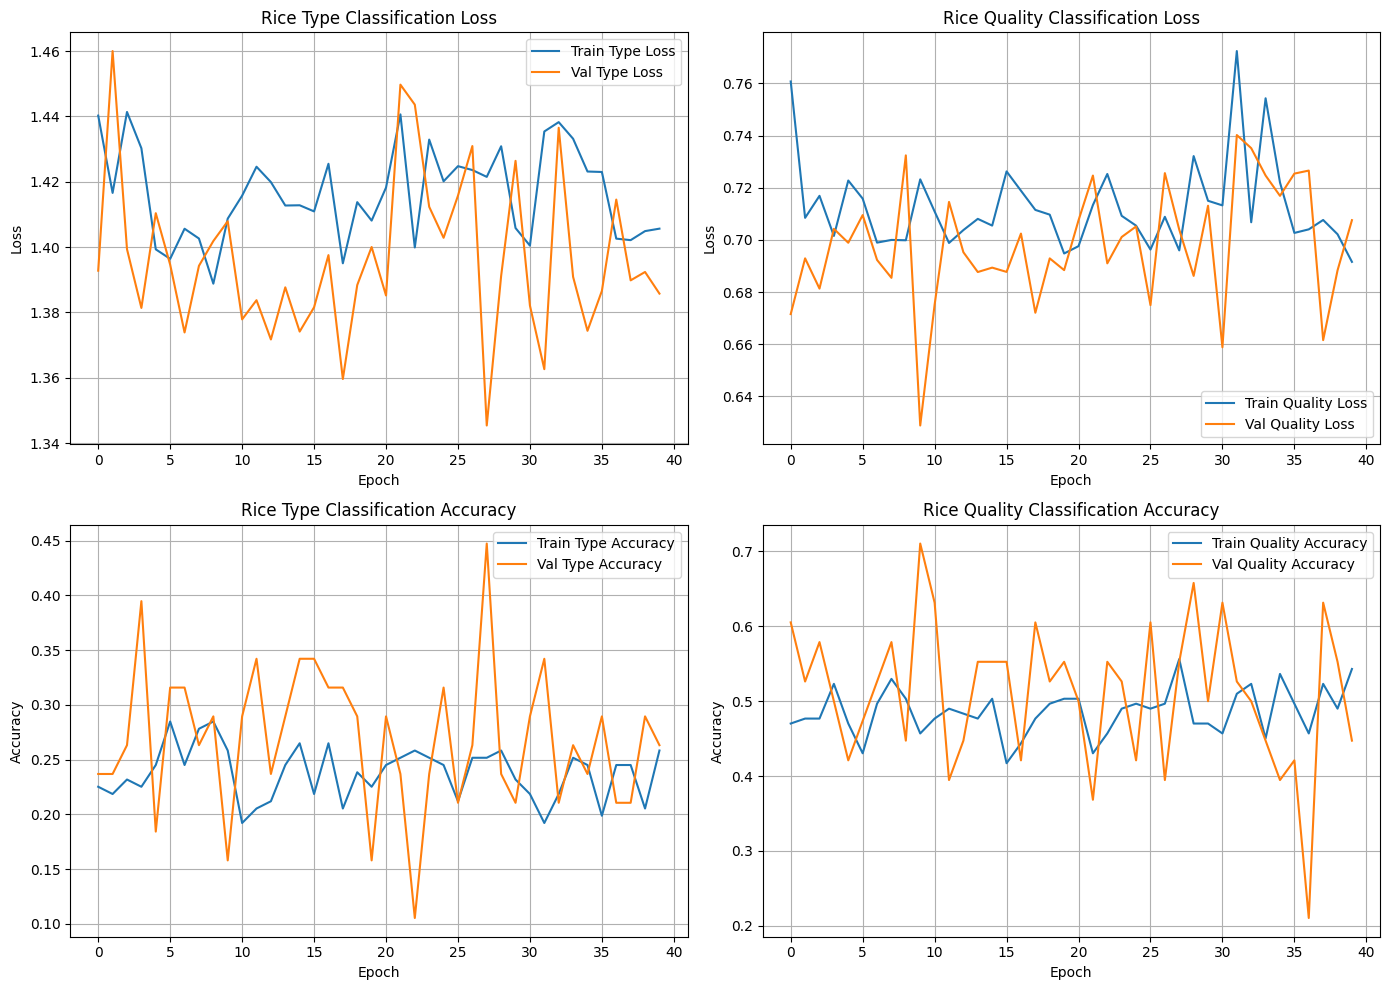


TRAINING ANALYSIS SUMMARY

Final Training Metrics:
  Type Loss: 1.4056
  Type Accuracy: 0.2583
  Quality Loss: 0.6916
  Quality Accuracy: 0.5430

Final Validation Metrics:
  Type Loss: 1.3858
  Type Accuracy: 0.2632
  Quality Loss: 0.7076
  Quality Accuracy: 0.4474

Overfitting Analysis:
  Type Loss Difference (Val - Train): -0.0199
  Quality Loss Difference (Val - Train): 0.0160
  ✓ Good generalization


In [171]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Type loss
axes[0, 0].plot(history.history['type_loss'], label='Train Type Loss')
axes[0, 0].plot(history.history['val_type_loss'], label='Val Type Loss')
axes[0, 0].set_title('Rice Type Classification Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Quality loss
axes[0, 1].plot(history.history['quality_loss'], label='Train Quality Loss')
axes[0, 1].plot(history.history['val_quality_loss'], label='Val Quality Loss')
axes[0, 1].set_title('Rice Quality Classification Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Type accuracy
axes[1, 0].plot(history.history['type_accuracy'], label='Train Type Accuracy')
axes[1, 0].plot(history.history['val_type_accuracy'], label='Val Type Accuracy')
axes[1, 0].set_title('Rice Type Classification Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quality accuracy
axes[1, 1].plot(history.history['quality_accuracy'], label='Train Quality Accuracy')
axes[1, 1].plot(history.history['val_quality_accuracy'], label='Val Quality Accuracy')
axes[1, 1].set_title('Rice Quality Classification Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("TRAINING ANALYSIS SUMMARY")
print("="*60)
print(f"\nFinal Training Metrics:")
print(f"  Type Loss: {history.history['type_loss'][-1]:.4f}")
print(f"  Type Accuracy: {history.history['type_accuracy'][-1]:.4f}")
print(f"  Quality Loss: {history.history['quality_loss'][-1]:.4f}")
print(f"  Quality Accuracy: {history.history['quality_accuracy'][-1]:.4f}")

print(f"\nFinal Validation Metrics:")
print(f"  Type Loss: {history.history['val_type_loss'][-1]:.4f}")
print(f"  Type Accuracy: {history.history['val_type_accuracy'][-1]:.4f}")
print(f"  Quality Loss: {history.history['val_quality_loss'][-1]:.4f}")
print(f"  Quality Accuracy: {history.history['val_quality_accuracy'][-1]:.4f}")

print(f"\nOverfitting Analysis:")
type_loss_diff = history.history['val_type_loss'][-1] - history.history['type_loss'][-1]
quality_loss_diff = history.history['val_quality_loss'][-1] - history.history['quality_loss'][-1]
print(f"  Type Loss Difference (Val - Train): {type_loss_diff:.4f}")
print(f"  Quality Loss Difference (Val - Train): {quality_loss_diff:.4f}")

if type_loss_diff > 0.1 or quality_loss_diff > 0.1:
    print("  ⚠️  Possible overfitting detected")
else:
    print("  ✓ Good generalization")

print("="*60)